In [85]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
import matplotlib.colors as mcolors
from torch import Tensor, stack
from livelossplot import PlotLosses

# Set the size of the graph and the subgraph
n = 20  # Number of nodes in the graph
m = 5  # Number of nodes in the subgraph

# Generate a random adjacency matrix A
A_upper = np.triu(np.random.randint(0, 2, size=(n, n)), k=1)
A = A_upper + A_upper.T

# Set diagonal elements to zero to remove self-loops
np.fill_diagonal(A, 0)

# Create a graph from the adjacency matrix
G = nx.from_numpy_array(A)

# Generate a random subset of nodes for the subgraph
subgraph_nodes = np.random.choice(G.nodes(), size=m, replace=False)

# Create the subgraph by keeping only the edges that connect the selected subset of nodes
G_sub = G.subgraph(subgraph_nodes)

# Generate a list of colors for nodes and edges
node_colors = ['red' if node in G_sub.nodes() else 'green' for node in G.nodes()]
edge_colors = ['red' if edge in G_sub.edges() else 'green' for edge in G.edges()]


In [86]:
def plot_graph_with_colors(G, G_sub, w=None, title=''):
    if w is None:
        # Generate a list of colors for nodes, red for subgraph nodes and green for the rest
        node_colors = ['red' if node in G_sub.nodes() else 'green' for node in
                       G.nodes()]

        # Generate a list of colors for edges, red for subgraph edges and green for the rest
        edge_colors = ['red' if edge in G_sub.edges() else 'green' for edge in
                       G.edges()]
    else:
        # Define a reversed colormap with green for w=1, red for w=0, and interpolate in between
        cmap = mcolors.LinearSegmentedColormap.from_list('my_cmap',
                                                         ['red', 'yellow', 'green'])

        # Normalize w to match the colormap range
        norm = mcolors.Normalize(vmin=0, vmax=1)

        # Generate a list of colors for nodes based on w values
        node_colors = [cmap(norm(weight.item())) for weight in w]

        # Generate a list of colors for edges based on the nodes they connect
        edge_colors = [cmap(norm((w[u] + w[v]) / 2.0)) for u, v in G.edges()]

    # Set a fixed seed for the layout algorithm
    seed = 42
    pos = nx.spring_layout(G, seed=seed)  # Layout algorithm for graph visualization

    # Draw the graph with node and edge colors
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors)
    plt.axis('off')  # Turn off the axis

    # Add colorbar
    if w is not None:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        plt.colorbar(sm)
    plt.title(title)
    plt.show()

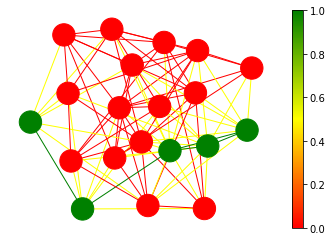

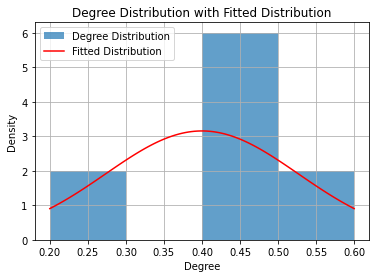

First 4 moments: ['0.40', '0.18', '0.08', '0.04', '0.02', '0.01', '0.01', '0.00', '0.00', '0.00']


In [87]:
from scipy.stats import norm


# Assuming you have your graph G and subgraph G_sub defined

# Generate a tensor w with values between 0 and 1
w_indicator = torch.zeros(len(G.nodes()))

# Set the indices corresponding to the subgraph nodes to 1
subgraph_node_indices = [list(G.nodes()).index(node) for node in G_sub.nodes()]
w_indicator[subgraph_node_indices] = 1.0

# Call the function to plot the graph with colors
plot_graph_with_colors(G, G_sub, w_indicator)


def plot_degree_distribution(graph, k=4):
    # Get the degree sequence of the graph
    n = graph.number_of_nodes()
    degree_sequence = [degree/n for _, degree in graph.degree()]

    # Plot the degree distribution
    plt.hist(degree_sequence, bins='auto', alpha=0.7, density=True, label='Degree Distribution')

    # Fit a distribution to the data
    mu, std = norm.fit(degree_sequence)
    x = np.linspace(min(degree_sequence), max(degree_sequence), 100)
    y = norm.pdf(x, mu, std)
    plt.plot(x, y, 'r-', label='Fitted Distribution')

    plt.xlabel('Degree')
    plt.ylabel('Density')
    plt.title('Degree Distribution with Fitted Distribution')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Compute the first k moments
    moments = [np.mean(degree_sequence)]
    for i in range(2, k + 1):
        moments.append(np.mean(np.power(degree_sequence, i)))

    return moments



# Plot degree distribution and compute first 4 moments
moments = plot_degree_distribution(G_sub, k=10)
print(f"First 4 moments: {[f'{value:.2f}' for value in moments]}")

In [88]:
def find_smallest_eigenvector(A):
    eigenvalues, eigenvectors = torch.symeig(A, eigenvectors=True)

    # Find the index of the smallest eigenvalue in abs val
    smallest_eigenvalue_index = torch.argmin(eigenvalues.abs())

    # Get the smallest eigenvalue and eigenvector
    smallest_eigenvalue = eigenvalues[smallest_eigenvalue_index]
    smallest_eigenvector = eigenvectors[:, smallest_eigenvalue_index]
    return smallest_eigenvalue, smallest_eigenvector


def inverse_power_method(A, epsilon=1e-5, max_iterations=100):
    # Initialize a random vector as the starting eigenvector estimate
    n = A.shape[0]
    v = torch.randn(n, 1)
    v = v / torch.norm(v)  # Normalize the vector

    # Perform the inverse power method
    for _ in range(max_iterations):
        v_prev = v

        # Compute the next estimate of the eigenvector
        v = torch.linalg.solve(A, v)
        v = v / torch.norm(v)  # Normalize the vector

        # Compute the corresponding eigenvalue
        eigenvalue = torch.mm(torch.mm(v_prev.t(), A), v) / torch.mm(v_prev.t(), v)

        # Check for convergence
        if torch.norm(v - v_prev) < epsilon:
            break

    return eigenvalue.item(), v


def spectral_subgraph_localization(A: Tensor,
                                   spectral_op,
                                   params,
                                   obj_fun,
                                   w: Tensor = None, ):
    if w is None:
        w = torch.ones(A.shape[0])
    n = A.shape[0]
    s = 1 / (params["scale"] ** 2)
    for i in range(params["maxiter"]):
        H = spectral_op(A, w, params)
        #C = (torch.eye(n) - s * w @ w.T) @ H @ H @ (torch.eye(n) - s * w @ w.T)
        # Compute eigenvalues and eigenvectors of A
        e, v = find_smallest_eigenvector(H)
        #e,v = inverse_power_method(A = H, epsilon=1e-8, max_iterations=500)
        # w = params["scale"] * v
        # w = v / torch.norm(v, float('inf'))
        # w = params["scale"] * w
        w = v / v.sum()
        #obj = w.T @ H @ w +params["c"]**2
        obj = obj_fun(A, w, params)
    return w, obj


%% md

# op1 = lambda A, w, params: ((A.T @ w) @ (w.T @ A) - 2 * params["c"] * A+(params["c"]/params["scale"])**2*torch.eye(n))
op1 = lambda A, w, params: (A - params["c"] * torch.eye(A.shape[0]))
obj_fun = lambda A, w, params: (w.T @ A @ w - params["c"]) ** 2
obj_quad_fun = lambda A, w, params: (w.T @ op1(A, w, params) @ w)

w_gt = w_indicator[:, None].float() / w_indicator.sum()
A_tensor = torch.tensor(A).float()
c = w_gt.T @ A_tensor @ w_gt
params = {}
params["c"] = c
params["maxiter"] = 1
params["w_gt"] = w_gt
params["scale"] = 1 / np.sqrt(len(G_sub.nodes))


w_opt, obj_val = spectral_subgraph_localization(A=A_tensor,
                                                spectral_op=op1,
                                                params=params,
                                                w=w_gt,
                                                obj_fun=obj_fun)
w_star = (w_opt.numpy() / w_opt.sum()) * m
#w_star = w_opt
plot_graph_with_colors(G, G_sub, w_star, 'w_star')
plot_graph_with_colors(G, G_sub, w_gt * m, 'w_gt')

In [106]:
import torch
from torch import nn, optim
import torch.nn.functional as F

DTYPE = torch.float64


class MaskGeneratorNetwork(nn.Module):
    def __init__(self, n, n_moments):
        super().__init__()
        self._n = n
        self.weights = nn.Parameter(
            torch.randn(n, 1,
                        dtype=DTYPE))  # This will be our trainable parameter vector
        self._n_moments = n_moments

    def forward(self, A):
        w = F.softmax(self.weights, dim=0)  # Apply softmax to get the vector w
        embedding = self.compute_moments(w, A, self._n_moments)  # Compute w^T @ A @ w
        return embedding

    @staticmethod
    def compute_moments(w, A, n_moments):
        mean = w.T @ A @ w
        moments = [mean]
        if n_moments >= 2:
            for k in range(2, n_moments):
                mom = w.T @ ((A @ w - mean) ** k)
                moments.append(mom)
        return torch.cat(moments).squeeze()

# op1 = lambda A, w, params: ((A.T @ w) @ (w.T @ A) - 2 * params["c"] * A+(params["c"]/params["scale"])**2*torch.eye(n))
loss_fun = torch.nn.MSELoss()
w_gt = (w_indicator[:, None].float() / w_indicator.sum()).type(DTYPE)
A_tensor = torch.tensor(A).type(DTYPE)
c = w_gt.T @ A_tensor @ w_gt
params = {}
params["maxiter"] = 5000
params["lr"] = 0.2
params["n_moments"] = 4
params["k_update_plot"] = 500
params["embedding_gt"] = MaskGeneratorNetwork.compute_moments(w_gt, A_tensor,
                                                              params["n_moments"]).type(DTYPE)
mask_generator = MaskGeneratorNetwork(n=n,n_moments=params["n_moments"])


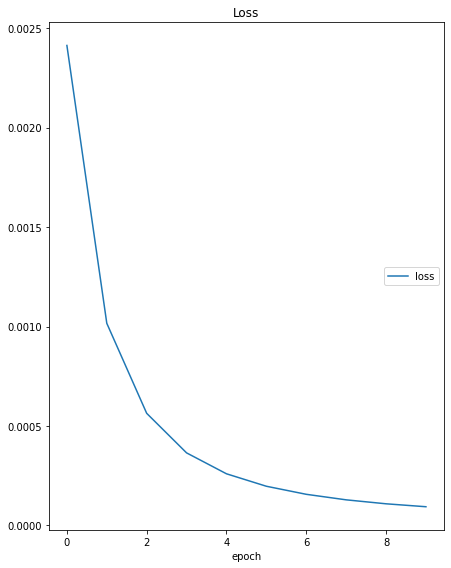

Loss
	loss             	 (min:    0.000, max:    0.002, cur:    0.000)


In [107]:

def nn_subgraph_localization(A: torch.Tensor,
                             mask_generator: MaskGeneratorNetwork,
                             params: dict,
                             loss_function):
    # Create your optimizer
    lr = params['lr']
    embedding_gt = params['embedding_gt']
    optimizer = optim.SGD(mask_generator.parameters(), lr=lr)

    liveloss = PlotLosses()

    for iteration in range(params["maxiter"]):
        # Set the model to training mode
        mask_generator.train()
        embedding = mask_generator(A)
        loss = loss_function(embedding, embedding_gt)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if iteration % params['k_update_plot'] == 0:
            print(f"Iteration {iteration}, Loss: {loss.item()}")
            liveloss.update({'loss': loss.item()})
            liveloss.send()
            liveloss.draw()

nn_subgraph_localization(A=A_tensor,
                         mask_generator=mask_generator,
                         params=params,
                         loss_function=loss_fun)


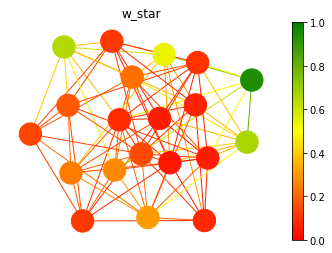

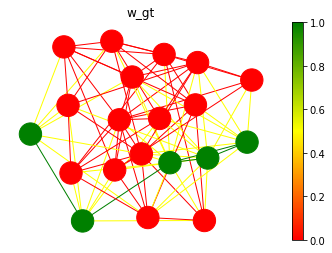

gt moments: ['0.4000', '0.0160', '-0.0000']
est moments: ['0.3869', '0.0073', '0.0004']


In [108]:
from torch import stack

opt_weights = F.softmax(mask_generator.weights, dim=0)
w_star = opt_weights.detach().numpy()
est_moments = MaskGeneratorNetwork.compute_moments(opt_weights, A_tensor,params["n_moments"]).type(DTYPE)
plot_graph_with_colors(G, G_sub, (w_star * m), 'w_star')
plot_graph_with_colors(G, G_sub, w_gt * m, 'w_gt')

print(f"gt moments: {[f'{value:.4f}' for value in params['embedding_gt']]}")
print(f"est moments: {[f'{value:.4f}' for value in est_moments]}")